In [59]:
import pandas as pd
from bokeh.io import show, output_file
from bokeh.plotting import figure

marketing=pd.read_csv("data/marketing_new.csv",index_col=0)

In [66]:
marketing.head()

3.7.3.final.0


I want to look at how conversion rate differs by various groups in the data. I will write a function to calculate the conversion rate by any arbitrary grouping so that I can look at many different slices quickly. 

1. The function first filters for converted users & counts the number of by group as num_conv (a series object).

2. Then it counts the total number of users in the group as total (also a series)

3. It returns a series object with a conversion rate by group


In [4]:
def get_conversion_rate(df, grouping):
    num_conv = df[df['converted'] == True]\
                       .groupby(grouping)['user_id'].nunique()

    total = df.groupby(grouping)['user_id'].nunique()   
    
    conversion_rate = num_conv/total
    
    conversion_rate = conversion_rate.fillna(0)
    
    return conversion_rate


I can then call it for many different groupings...

In [5]:
#by age group 
get_conversion_rate(marketing,['age_group'])

age_group
0-18 years     0.160596
19-24 years    0.234124
24-30 years    0.188525
30-36 years    0.074599
36-45 years    0.071834
45-55 years    0.072779
55+ years      0.079511
Name: user_id, dtype: float64

In [6]:
#multiple groupings
get_conversion_rate(marketing,['date_served','marketing_channel']).head(15)

date_served  marketing_channel
2018-01-01   Email                1.000000
             Facebook             0.117647
             House Ads            0.084656
             Instagram            0.106667
             Push                 0.083333
2018-01-02   Email                1.000000
             Facebook             0.098361
             House Ads            0.077982
             Instagram            0.129032
             Push                 0.055556
2018-01-03   Email                0.000000
             Facebook             0.080645
             House Ads            0.088542
             Instagram            0.171875
             Push                 0.083333
Name: user_id, dtype: float64

When I group by two columns, I see that the conversion for the email channel is 100% on some days but 0% on others.This is strange, so it would be useful to know what the actual #'s were for converted users and total users. It might be the case that no emails were sent on 1-03. 
So what if my function instead returns a dataframe that also has a column with # converted & # total ? 

I will again create the two series objects but will this time merge them to keep both of their values and assign a new column for conversion rate. I need to use an outer join and fill NA to 0 to keep all rows (otherwise Email on 1-03 would be dropped since no conversions on this date). 

In [7]:
def get_conversion_rate(df,grouping):
    num_convs=df[df['converted'] == True]\
                       .groupby(grouping)['user_id'].nunique().rename('num_converted')

    total = df.groupby(grouping)['user_id'].nunique().rename('num_total')

    conv_rate=pd.merge(num_convs,total,left_index=True,right_index=True,how='outer')\
        .assign(not_conv=lambda x: x['num_total']-x['num_converted'],conv_rate=lambda x: x['num_converted']/x['num_total'])\
        .fillna(0)
    return conv_rate.reset_index()

get_conversion_rate(marketing,['marketing_channel'])





,marketing_channel,num_converted,num_total,not_conv,conv_rate
0,Email,187,553,366,0.338156
1,Facebook,221,1758,1537,0.125711
2,House Ads,298,3968,3670,0.075101
3,Instagram,232,1740,1508,0.133333
4,Push,77,972,895,0.079218


In [9]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import RdBu3,Spectral5
from bokeh.transform import factor_cmap


def make_plot(df,col_name):
    
    grouped=get_conversion_rate(df,[col_name])
    
    source = ColumnDataSource(grouped)
    group=source.data[col_name].tolist()

    group_cmap = factor_cmap(col_name, palette=Spectral5, factors=sorted(grouped[col_name].unique()))

    title="Conversion by: " + col_name
    p = figure(plot_height=350, x_range=group, title=title)

    p.vbar(x=col_name, top='num_converted', width=1,
       line_color=group_cmap, fill_color=group_cmap,source=source)
        
    p.y_range.start = 0
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label =col_name
    p.xaxis.major_label_orientation = 1.2
    p.outline_line_color = None
    
    return p

show(make_plot(marketing,'marketing_channel'))

From this, it is more clear that the email channel is so small that the conversion rate is not meaningful. 

### Bokeh Visualizations



Get grouped dataframe with counts

In [9]:
#stacked bar

stacks=['num_converted','not_conv']
colors = ["#c9d9d3", "#e84d60"]

p2 = figure(plot_height=350, plot_width=500, x_range=group, title="Stacked Conversion By Channel",
           toolbar_location=None, tools="")

p2.vbar_stack(stacks, x='marketing_channel',width=0.6, color=colors, source=source,
             legend_label=['Converted','Not Converted'])

hover_tool = HoverTool(tooltips=[
            ('Conversions', '@num_converted'),
            ('Non-conversions', '@not_conv'),
            ('channel', '@marketing_channel'),
        ])

p2.tools.append(hover_tool)

p2.y_range.start = 0
p2.xgrid.grid_line_color = None
p2.xaxis.axis_label = 'marketing_channel'
p2.xaxis.major_label_orientation = 1.2
p2.outline_line_color = None

show(p2)

### Modeling
Now I will build some simple models to predict conversion from a subset of features

In [67]:
from sklearn.model_selection import train_test_split
X = marketing[['marketing_channel','subscribing_channel','age_group']]
y = marketing['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


['marketing_channel', 'subscribing_channel', 'age_group']

In [57]:
import pickle
import pandas as pd
import numpy as np

loaded_model=pickle.load(open("model.pkl","rb"))
json={"marketing_channel": "House Ads", "subscribing_channel": "Instagram", "age_group": "55+ years"}  
query = pd.DataFrame([json])
print(query)

def pred(query):
    p=loaded_model.predict_proba(query)
    
    p=tuple(p[0,])
    if p[0]>.5:
        print(str(p[0]*100)+'%')
        return False
    else:
        print(p[1]*100)
        return True
    

pred(query)






   age_group marketing_channel subscribing_channel
0  55+ years         House Ads           Instagram
100.0%


False

In [44]:
categorical_pipelines = []


for i n range(len(catg_feat)): 
    if col in CATEGORICAL_COLUMNS:
        scores = []
        # Build the scores array
        for j in range(len(COLUMNS[:-1])):
            if i == j: 
                scores.append(1) # Set to 1 to select this column
            else: # Every other column should be ignored.
                scores.append(0)
        skb = SelectKBest(k=1)
        skb.scores_ = scores
        # Convert the categorical column to a numerical value
        lbn = LabelBinarizer()
        r = skb.transform(train_features)
        lbn.fit(r)
        # Create the pipeline to extract the categorical feature
        categorical_pipelines.append(
            ('categorical-{}'.format(i), Pipeline([
                ('SKB-{}'.format(i), skb),
                ('LBN-{}'.format(i), lbn)])))

# Create pipeline to extract the numerical features
skb = SelectKBest(k=6)
# From COLUMNS use the features that are numerical
skb.scores_ = [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
categorical_pipelines.append(('numerical', skb))

SyntaxError: invalid syntax (<ipython-input-44-d0aeb51a6ffc>, line 4)

Since I am only using categorical features, I will build a preprocessing pipeline to fill missing values with 'missing'
and one hot encode category types
I will compare logistic regression and a decision tree classifier. 

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

catg_feat = ['marketing_channel','subscribing_channel','age_group']
lb = LabelEncoder() 
  
mapping_dict ={} 
for i in range(len(catg_feat)): 
    r = skb.transform(train_features)
        lbn.fit(r)
    print(labelEncoder.transform(X_train[['marketing_channel']]))
  
    le_name_mapping = dict(zip(labelEncoder.classes_, 
                        labelEncoder.transform(labelEncoder.classes_))) 
  
    mapping_dict[col]= le_name_mapping 
print(mapping_dict) 

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('lb', LabelEncoder())])


# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorical_features)])


# def make_preds(classifier):
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
#     model=pipe.fit(X_train, y_train)
#     print(classifier)
#     print("model score: ",pipe.score(X_test, y_test))
#     y_pred = pipe.predict(X_test)
#     return model,y_pred

# lg_model,lg_pred=make_preds(LogisticRegression(solver='lbfgs'))
# dt_model,dt_pred=make_preds(DecisionTreeClassifier(max_depth=4))

IndentationError: unexpected indent (<ipython-input-87-c63b68e012b9>, line 14)

In [13]:
feature_names = dt_model.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['onehot'].get_feature_names(categorical_features)

feature_names


array(['marketing_channel_Email', 'marketing_channel_Facebook',
       'marketing_channel_House Ads', 'marketing_channel_Instagram',
       'marketing_channel_Push', 'marketing_channel_missing',
       'subscribing_channel_Email', 'subscribing_channel_Facebook',
       'subscribing_channel_House Ads', 'subscribing_channel_Instagram',
       'subscribing_channel_Push', 'subscribing_channel_missing',
       'age_group_0-18 years', 'age_group_19-24 years',
       'age_group_24-30 years', 'age_group_30-36 years',
       'age_group_36-45 years', 'age_group_45-55 years',
       'age_group_55+ years'], dtype=object)

C:\Users\mikay\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


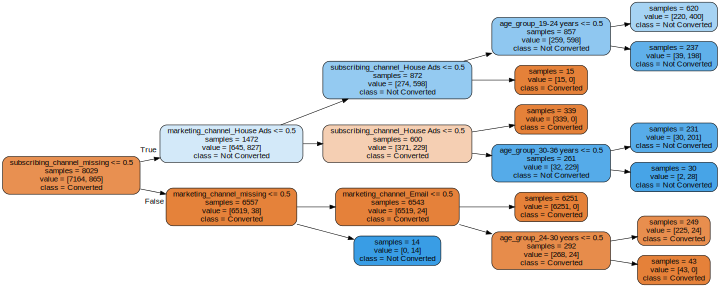

In [14]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\mikay\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'


dot_data = export_graphviz(dt_model['classifier'], out_file=None, feature_names = feature_names,
                class_names = ['Converted','Not Converted'],
                rounded = True, proportion = False, precision = 1, rotate=True,impurity=False,filled=True)

pdot = pydotplus.graph_from_dot_data(dot_data)
pdot.set_graph_defaults(size = "\"10,7\"",fontsize='14')
graph = graphviz.Source(pdot.to_string())
graph


In [15]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

def plot_tree(crit, split, depth, min_split, min_leaf):
    classifier = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    model=pipe.fit(X_train, y_train)
    
    feature_names = dt_model.named_steps['preprocessor'].transformers_[0][1]\
        .named_steps['onehot'].get_feature_names(categorical_features)
    
    graph = Source(export_graphviz(model['classifier']
      , out_file=None
      , feature_names=feature_names
      , class_names=['Converted','Not Converted']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return model['classifier']

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[3,4]
   , min_split=(0.1,1)
   , min_leaf=(1,2))


display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

##### Returns dataframe with one colume for y_test (actual) and one column for y_pred (predicted value)

In [16]:
def get_preds_df(y_pred):
    y_test.rename('y_actual',inplace=True)
    preds_df = pd.DataFrame(data = y_pred, columns = ['y_pred'], index = X_test.index.copy())
    return X_test.merge(preds_df,how='inner',left_index = True, right_index = True).merge(y_test,left_index = True, right_index = True)

dt_preds_df=get_preds_df(dt_pred)
dt_preds_df.head()

,marketing_channel,subscribing_channel,age_group,y_pred,y_actual
885,House Ads,Instagram,45-55 years,False,False
2288,Instagram,NaN,36-45 years,False,False
9684,House Ads,NaN,36-45 years,False,False
7444,House Ads,NaN,19-24 years,False,False
4780,House Ads,NaN,24-30 years,False,False


In [17]:
def pred_types(preds_df):
    tp=preds_df[(preds_df.y_actual==True) & (preds_df.y_pred==True)]
    tn=preds_df[(preds_df.y_actual==False) & (preds_df.y_pred==False)]
    fp=preds_df[(preds_df.y_actual==False) & (preds_df.y_pred==True)]
    fn=preds_df[(preds_df.y_actual==True) & (preds_df.y_pred==False)]
    return tp,tn,fp,fn

tp,tn,fp,fn=pred_types(dt_preds_df)

fp.head()

,marketing_channel,subscribing_channel,age_group,y_pred,y_actual
1070,Facebook,Facebook,36-45 years,True,False
1510,Push,Facebook,36-45 years,True,False
1294,Facebook,Instagram,36-45 years,True,False
920,Instagram,Instagram,24-30 years,True,False
783,Facebook,Instagram,24-30 years,True,False


In [19]:
def make_model(feat):
    X = marketing[[feat]]
    y = marketing['converted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    categorical_features = X_train.select_dtypes(include=['object']).columns

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(max_depth=4))])
    model=pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print("model score: ",pipe.score(X_test, y_test))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

inter=interactive(make_model 
   , feat = ['marketing_channel','subscribing_channel','variant','age_group'])

display(inter)

interactive(children=(Dropdown(description='feat', options=('marketing_channel', 'subscribing_channel', 'varia…

In [78]:
import pickle
loaded_model=pickle.load(open("model.pkl","rb"))

In [35]:
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import pickle
    
    
# def ValuePredictor(to_predict_list):
#     to_predict = np.array(to_predict_list).reshape(1,13)
#     loaded_model = pickle.load(open("model.pkl","rb"))
#     result = loaded_model.predict(to_predict)
#     return result[0]


# example_list=[44,3,15,10,1,6,0,2,1,7688,0,40,38]
# print(ValuePredictor(example_list))

X_test.head()

,marketing_channel,subscribing_channel,age_group
885,House Ads,Instagram,45-55 years
2288,Instagram,NaN,36-45 years
9684,House Ads,NaN,36-45 years
7444,House Ads,NaN,19-24 years
4780,House Ads,NaN,24-30 years


In [79]:
import numpy as np
loaded_model.predict(np.array(['Email','Email','0-18 years']).reshape(1,3))
loaded_model.predict(np.array([0,0,0]).reshape(1,3))

ValueError: Specifying the columns using strings is only supported for pandas DataFrames